# 🔍 Eksploracja Bazy Danych Qdrant

Ten notebook pozwala na podgląd zawartości bazy danych Qdrant z transkryptami podcastów.

## Setup i Konfiguracja

In [12]:
import os
from pathlib import Path
import pandas as pd
from dotenv import load_dotenv
from qdrant_client import QdrantClient

# Załaduj zmienne środowiskowe
load_dotenv()

# Konfiguracja
QDRANT_URL = os.getenv("QDRANT_URL", "http://localhost:6333")
COLLECTION_NAME = os.getenv("QDRANT_COLLECTION", "podcasts_transcripts")

# Połącz się z Qdrant
client = QdrantClient(url=QDRANT_URL)

print(f"✅ Połączono z Qdrant: {QDRANT_URL}")
print(f"📚 Kolekcja: {COLLECTION_NAME}")

✅ Połączono z Qdrant: http://localhost:6333
📚 Kolekcja: podcasts_transcripts


## Informacje o Kolekcji

In [13]:
# Pobierz informacje o kolekcji
collection_info = client.get_collection(COLLECTION_NAME)

print(f"Nazwa kolekcji: {collection_info.config.params}")
print("\n📊 Statystyki:")
print(f"  - Liczba punktów: {collection_info.points_count}")
print(f"  - Liczba wektorów: {collection_info.vectors_count}")
print(f"  - Status: {collection_info.status}")
print("\n🎯 Konfiguracja wektorów:")
print(f"  - Wymiary: {collection_info.config.params.vectors.size}")
print(f"  - Metryka odległości: {collection_info.config.params.vectors.distance}")

Nazwa kolekcji: vectors=VectorParams(size=512, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None) shard_number=1 sharding_method=None replication_factor=1 write_consistency_factor=1 read_fan_out_factor=None on_disk_payload=True sparse_vectors=None

📊 Statystyki:
  - Liczba punktów: 63
  - Liczba wektorów: None
  - Status: green

🎯 Konfiguracja wektorów:
  - Wymiary: 512
  - Metryka odległości: Cosine


## Podgląd Danych - Pierwsze 5 Punktów

In [14]:
# Pobierz pierwsze 5 punktów
points = client.scroll(
    collection_name=COLLECTION_NAME,
    limit=5,
    with_payload=True,
    with_vectors=False  # Nie pobieraj wektorów (512 wymiarów)
)

print(f"\n📄 Pierwsze {len(points[0])} punktów:\n")
print("=" * 80)

for point in points[0]:
    payload = point.payload
    print(f"\n🆔 ID: {point.id}")
    print(f"📌 Original ID: {payload.get('original_id', 'N/A')}")
    print(f"🎙️  Episode: {payload.get('episode_title', 'N/A')}")
    print(f"📖 Section: {payload.get('section_heading', 'N/A')}")
    print(f"🏷️  Tags: {', '.join(payload.get('tags', []))}")
    print(f"📝 Content (pierwsze 100 znaków): {payload.get('content', '')[:100]}...")
    print(f"💡 Key Points: {len(payload.get('key_points', []))}")
    print("=" * 80)


📄 Pierwsze 5 punktów:


🆔 ID: 1
📌 Original ID: ep_002_section_1
🎙️  Episode: Czego NIE MOŻE zawierać firmowa strona internetowa?
📖 Section: O Wise Group i kontekst tworzenia stron
🏷️  Tags: strony internetowe, marketing B2B, strategia biznesowa, konwersja, user experience, web development, customer journey, digital marketing
📝 Content (pierwsze 100 znaków): Kanał powstaje dzięki Wise Group, grupie spółek, które pomagają firmom mądrze rosnąć. Cellwise dorad...
💡 Key Points: 2

🆔 ID: 2
📌 Original ID: ep_002_section_2
🎙️  Episode: Czego NIE MOŻE zawierać firmowa strona internetowa?
📖 Section: Wprowadzenie - ładność vs efektywność biznesowa
🏷️  Tags: strony internetowe, marketing B2B, strategia biznesowa, konwersja, user experience, web development, customer journey, digital marketing
📝 Content (pierwsze 100 znaków): Wielu właścicieli firm uważa, że ma dobrą stronę internetową, ale równie wielu uważa, że ma słabą. K...
💡 Key Points: 3

🆔 ID: 3
📌 Original ID: ep_002_section_3
🎙️  Episode: 

## Analiza Danych - Wszystkie Punkty

In [15]:
# Pobierz wszystkie punkty
all_points = []
offset = None

while True:
    points, offset = client.scroll(
        collection_name=COLLECTION_NAME,
        limit=100,
        offset=offset,
        with_payload=True,
        with_vectors=False
    )
    all_points.extend(points)
    if offset is None:
        break

print(f"✅ Pobrano {len(all_points)} punktów")

✅ Pobrano 63 punktów


## DataFrame z Metadanymi

In [16]:
# Konwersja do DataFrame
data = []
for point in all_points:
    payload = point.payload
    data.append({
        'id': point.id,
        'original_id': payload.get('original_id', ''),
        'episode_id': payload.get('episode_id', ''),
        'episode_title': payload.get('episode_title', ''),
        'section_heading': payload.get('section_heading', ''),
        'chunk_index': payload.get('chunk_index', 0),
        'content_length': len(payload.get('content', '')),
        'num_key_points': len(payload.get('key_points', [])),
        'num_tags': len(payload.get('tags', [])),
        'source_file': payload.get('source_file', ''),
    })

df = pd.DataFrame(data)
df.head(10)

,id,original_id,episode_id,episode_title,section_heading,chunk_index,content_length,num_key_points,num_tags,source_file
0,1,ep_002_section_1,ep_002,Czego NIE MOŻE zawierać firmowa strona interne...,O Wise Group i kontekst tworzenia stron,1,915,2,8,budowanie_strony_internetowej_b2b.json
1,2,ep_002_section_2,ep_002,Czego NIE MOŻE zawierać firmowa strona interne...,Wprowadzenie - ładność vs efektywność biznesowa,2,1276,3,8,budowanie_strony_internetowej_b2b.json
2,3,ep_002_section_3,ep_002,Czego NIE MOŻE zawierać firmowa strona interne...,Punkt 1-2: Brak odpowiedzi na pytania i nieroz...,3,4798,4,8,budowanie_strony_internetowej_b2b.json
3,4,ep_002_section_4,ep_002,Czego NIE MOŻE zawierać firmowa strona interne...,Punkt 3-4: Brak ścieżki klienta i stawianie ba...,4,4200,4,8,budowanie_strony_internetowej_b2b.json
4,5,ep_002_section_5,ep_002,Czego NIE MOŻE zawierać firmowa strona interne...,Punkt 5-6: Pomnik w kamieniu i nadmiar kreatyw...,5,3964,4,8,budowanie_strony_internetowej_b2b.json
5,6,ep_002_section_6,ep_002,Czego NIE MOŻE zawierać firmowa strona interne...,Punkt 7-8: Wolna strona i niespójność wizualna,6,1506,4,8,budowanie_strony_internetowej_b2b.json
6,7,ep_002_section_7,ep_002,Czego NIE MOŻE zawierać firmowa strona interne...,Podsumowanie 8 cech słabej strony,7,1391,2,8,budowanie_strony_internetowej_b2b.json
7,8,ep_002_section_8,ep_002,Czego NIE MOŻE zawierać firmowa strona interne...,4 typy wykonawców stron internetowych,8,4200,4,8,budowanie_strony_internetowej_b2b.json
8,9,ep_002_section_9,ep_002,Czego NIE MOŻE zawierać firmowa strona interne...,Dlaczego strategia jest kluczowa,9,1563,4,8,budowanie_strony_internetowej_b2b.json
9,10,ep_005_section_1,ep_005,5 fundamentów pozyskiwania klientów,Wprowadzenie i kontekst rynkowy,1,665,3,8,fundamenty_pozyskiwania_klientow.json


## Statystyki

In [17]:
print("📊 Statystyki bazy danych:\n")
print(f"Całkowita liczba sekcji: {len(df)}")
print(f"Liczba unikalnych epizodów: {df['episode_id'].nunique()}")
print(f"Liczba plików źródłowych: {df['source_file'].nunique()}")
print("\n📏 Długość contentu:")
print(f"  - Średnia: {df['content_length'].mean():.0f} znaków")
print(f"  - Mediana: {df['content_length'].median():.0f} znaków")
print(f"  - Min: {df['content_length'].min()} znaków")
print(f"  - Max: {df['content_length'].max()} znaków")
print("\n💡 Key points:")
print(f"  - Średnia na sekcję: {df['num_key_points'].mean():.1f}")
print(f"  - Całkowita liczba: {df['num_key_points'].sum()}")

📊 Statystyki bazy danych:

Całkowita liczba sekcji: 63
Liczba unikalnych epizodów: 6
Liczba plików źródłowych: 6

📏 Długość contentu:
  - Średnia: 2307 znaków
  - Mediana: 1726 znaków
  - Min: 302 znaków
  - Max: 8233 znaków

💡 Key points:
  - Średnia na sekcję: 3.3
  - Całkowita liczba: 208


## Podział na Epizody

In [18]:
# Liczba sekcji na epizod
episodes_stats = df.groupby('episode_id').agg({
    'episode_title': 'first',
    'section_heading': 'count',
    'content_length': 'sum',
    'num_key_points': 'sum'
}).rename(columns={
    'section_heading': 'num_sections',
    'content_length': 'total_content_length',
    'num_key_points': 'total_key_points'
})

episodes_stats = episodes_stats.sort_values('num_sections', ascending=False)
episodes_stats

,episode_title,num_sections,total_content_length,total_key_points
episode_id,,,,
ep_001,Jak zbudować STRATEGIĘ BIZNESU w 35 minut? (Mo...,13,32142,42
ep_003,6 zasad skutecznego PROSPECTINGU! Pozyskiwanie...,12,18436,39
ep_004,"1 SPOSÓB, żeby klienci zgłaszali się do Ciebie...",12,19611,39
ep_002,Czego NIE MOŻE zawierać firmowa strona interne...,9,23813,31
ep_005,5 fundamentów pozyskiwania klientów,9,31156,30
ep_006,Jak wyróżnić się na tle konkurencji? 20 obszarów,8,20152,27


## Wizualizacje

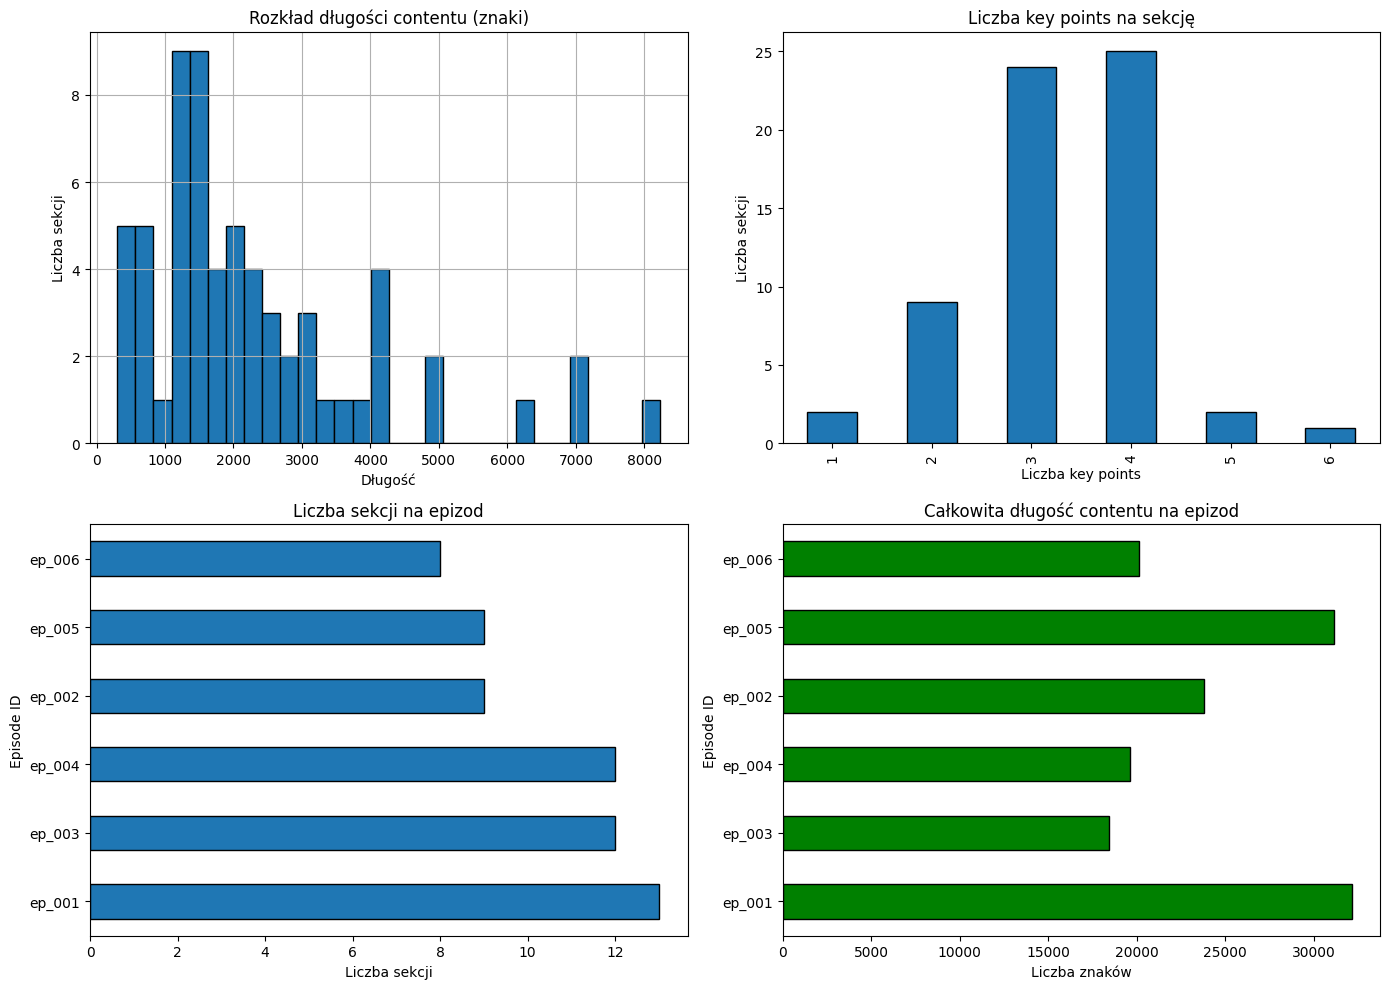

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Rozkład długości contentu
df['content_length'].hist(bins=30, ax=axes[0, 0], edgecolor='black')
axes[0, 0].set_title('Rozkład długości contentu (znaki)')
axes[0, 0].set_xlabel('Długość')
axes[0, 0].set_ylabel('Liczba sekcji')

# 2. Liczba key points na sekcję
df['num_key_points'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 1], edgecolor='black')
axes[0, 1].set_title('Liczba key points na sekcję')
axes[0, 1].set_xlabel('Liczba key points')
axes[0, 1].set_ylabel('Liczba sekcji')

# 3. Sekcje na epizod
episodes_stats['num_sections'].plot(kind='barh', ax=axes[1, 0], edgecolor='black')
axes[1, 0].set_title('Liczba sekcji na epizod')
axes[1, 0].set_xlabel('Liczba sekcji')
axes[1, 0].set_ylabel('Episode ID')

# 4. Całkowita długość contentu na epizod
episodes_stats['total_content_length'].plot(kind='barh', ax=axes[1, 1], edgecolor='black', color='green')
axes[1, 1].set_title('Całkowita długość contentu na epizod')
axes[1, 1].set_xlabel('Liczba znaków')
axes[1, 1].set_ylabel('Episode ID')

plt.tight_layout()
plt.show()

## Przykładowe Wyszukiwanie

Możesz tutaj przetestować proste wyszukiwanie po metadanych.

In [20]:
# Przykład: Wyszukaj sekcje z konkretnego epizodu
episode_to_search = df['episode_id'].iloc[0]  # Pierwszy epizod

episode_sections = df[df['episode_id'] == episode_to_search]

print(f"🎙️  Epizod: {episode_sections['episode_title'].iloc[0]}")
print(f"📚 Liczba sekcji: {len(episode_sections)}\n")

for idx, row in episode_sections.iterrows():
    print(f"📖 {row['section_heading']} (ID: {row['id']})")
    print(f"   Długość: {row['content_length']} znaków, Key points: {row['num_key_points']}")
    print()

🎙️  Epizod: Czego NIE MOŻE zawierać firmowa strona internetowa?
📚 Liczba sekcji: 9

📖 O Wise Group i kontekst tworzenia stron (ID: 1)
   Długość: 915 znaków, Key points: 2

📖 Wprowadzenie - ładność vs efektywność biznesowa (ID: 2)
   Długość: 1276 znaków, Key points: 3

📖 Punkt 1-2: Brak odpowiedzi na pytania i nierozwiewanie obiekcji (ID: 3)
   Długość: 4798 znaków, Key points: 4

📖 Punkt 3-4: Brak ścieżki klienta i stawianie barier (ID: 4)
   Długość: 4200 znaków, Key points: 4

📖 Punkt 5-6: Pomnik w kamieniu i nadmiar kreatywności (ID: 5)
   Długość: 3964 znaków, Key points: 4

📖 Punkt 7-8: Wolna strona i niespójność wizualna (ID: 6)
   Długość: 1506 znaków, Key points: 4

📖 Podsumowanie 8 cech słabej strony (ID: 7)
   Długość: 1391 znaków, Key points: 2

📖 4 typy wykonawców stron internetowych (ID: 8)
   Długość: 4200 znaków, Key points: 4

📖 Dlaczego strategia jest kluczowa (ID: 9)
   Długość: 1563 znaków, Key points: 4



## Podgląd Konkretnego Punktu

In [21]:
# Wybierz ID punktu do podglądu
point_id = 1  # Zmień na dowolne ID

# Pobierz punkt
point = client.retrieve(
    collection_name=COLLECTION_NAME,
    ids=[point_id],
    with_payload=True,
    with_vectors=False
)[0]

payload = point.payload

print("=" * 80)
print(f"🆔 ID: {point.id}")
print(f"📌 Original ID: {payload.get('original_id')}")
print(f"🎙️  Episode: {payload.get('episode_title')}")
print(f"📝 Summary: {payload.get('summary', 'N/A')[:200]}...")
print(f"\n📖 Section: {payload.get('section_heading')}")
print(f"🏷️  Tags: {', '.join(payload.get('tags', []))}")
print(f"\n📄 Content:\n{payload.get('content', '')}")
print("\n💡 Key Points:")
for i, kp in enumerate(payload.get('key_points', []), 1):
    print(f"  {i}. {kp}")
print("=" * 80)

🆔 ID: 1
📌 Original ID: ep_002_section_1
🎙️  Episode: Czego NIE MOŻE zawierać firmowa strona internetowa?
📝 Summary: Odcinek wyjaśnia, jak rozpoznać słabą stronę internetową i dlaczego większość firmowych stron nie wspiera biznesu. Autor przedstawia 8 cech złych stron (od braku odpowiedzi na pytania klienta po probl...

📖 Section: O Wise Group i kontekst tworzenia stron
🏷️  Tags: strony internetowe, marketing B2B, strategia biznesowa, konwersja, user experience, web development, customer journey, digital marketing

📄 Content:
Kanał powstaje dzięki Wise Group, grupie spółek, które pomagają firmom mądrze rosnąć. Cellwise doradza, szkoli i wdraża narzędzia IT w sprzedaży B2B. Adwise projektuje i realizuje marketing B2B. Hwise specjalizuje się w rekrutacjach IHRze. Automate wdraża automatyzację oraz AI w firmach. Sprawdź więcej na wisegroup.pl.

My w Adwisie, naszej agencji marketingowej, zajmujemy się tworzeniem stron mniej więcej od trzech lat. Zaczęliśmy je tworzyć dla B2B dlatego, że no

In [ ]:
# Pobierz punkt Z wektorem
point_id = 1

point_with_vector = client.retrieve(
    collection_name=COLLECTION_NAME,
    ids=[point_id],
    with_payload=True,
    with_vectors=True  # Teraz pobieramy wektor!
)[0]

print(f"🆔 Punkt ID: {point_id}")
print(f"📌 Original ID: {point_with_vector.payload.get('original_id')}")
print(f"📖 Section: {point_with_vector.payload.get('section_heading')}")
print("\n🔢 Embedding (wektor):")
print(f"   - Wymiary: {len(point_with_vector.vector)}")
print(f"   - Typ: {type(point_with_vector.vector)}")
print(f"\n   Pierwsze 10 wartości: {point_with_vector.vector[:10]}")
print(f"   Ostatnie 10 wartości: {point_with_vector.vector[-10:]}")
print(f"\n   Zakres wartości: [{min(point_with_vector.vector):.4f}, {max(point_with_vector.vector):.4f}]")
print(f"   Średnia: {sum(point_with_vector.vector) / len(point_with_vector.vector):.4f}")

🆔 Punkt ID: 1
📌 Original ID: ep_002_section_1
📖 Section: O Wise Group i kontekst tworzenia stron

🔢 Embedding (wektor):
   - Wymiary: 512
   - Typ: <class 'list'>

   Pierwsze 10 wartości: [-0.010807664, 0.04052874, 0.031288855, 0.049835343, 0.056640167, -0.020547906, -0.105341375, -0.02159865, -0.021632008, -0.010649219]
   Ostatnie 10 wartości: [-0.051770046, 0.034624554, 0.05126969, 0.039027676, -0.038026966, -0.027669623, 0.020914832, -0.0012498447, -0.003502484, -0.048034064]

   Zakres wartości: [-0.1521, 0.1363]
   Średnia: -0.0040


## Podgląd Embeddingu (Wektora)

Każdy punkt ma 512-wymiarowy wektor (embedding) wygenerowany przez OpenAI.

## Eksport Danych do CSV (opcjonalnie)

In [11]:
# Zapisz DataFrame do CSV
output_file = "database_export.csv"
df.to_csv(output_file, index=False)
print(f"✅ Wyeksportowano dane do: {output_file}")

✅ Wyeksportowano dane do: database_export.csv
